This notebook takes processed mat/pickle files and makes a dataset for prediction.
In particular, given a history and prediction horizon, this generates all viable slices of a full trajectory.  This goes through all pickle files and constructs a dataset for k-fold cross validation.

In [1]:
#%matplotlib notebook

import glob
import numpy as np
import scipy.io as sio
import pickle
import matplotlib.pyplot as plt
import pdb
from pkl_reader import *
from datetime import datetime
import sklearn.utils as sku

Using TensorFlow backend.


In [2]:
''' CONFIG: CONSTANTS FOR EXECUTION '''

now = datetime.now()
dt_string = now.strftime('%m_%d_%H:%M:%S')
dataset_name = 'pilot_dataset_%s' % dt_string
shuffle = True   # if True, shuffle snippets according to seed (for test/train split)
seed = 0;
num_folds_cv = 5 # k-fold cross validation, number of splits (-1 = only provide full set of data)

prune_start=True          # remove stationary portion of ego's trajectory at the start
prune_end=True            # remove stationary portion of ego's trajectory at the end
min_vel_thresh=0.01       # velocity threshold (m/s) above which ego is considered moving
exclude_collisions=True  # return an empty trajectory if there was a collision

Nhist=5          # number of timesteps of motion history to predict with
Npred=20         # number of timesteps of prediction horizon
Nskip=5          # "stride" for sliding window of snippet selection
dt=0.1           # discretization (s) of full ego trajectory corresponding to N* above
ego_trans = False # whether or not to represent trajectory snippets in the ego frame
                 # if False, use the global map frame for all snippets

### TODO
* [ ] optional: complete outlier removal in bag_processing (see "Additional Notes").  Need to check time indices.
* [ ] optional: include source pkl name for snippet to trial association

In [3]:
save_ext = 'pkl'
# files_to_process = glob.glob('../examples/bags/*.%s' % save_ext)
files_to_process = glob.glob('../examples/bags/parking_p2_t2_e9_2019-11-04-16-42-32.pkl')

print('Found %d files to read: %s' % (len(files_to_process), files_to_process))

Found 1 files to read: ['../examples/bags/parking_p2_t2_e9_2019-11-04-16-42-32.pkl']


Processing

../examples/bags/parking_p2_t2_e9_2019-11-04-16-42-32.pkl
-0.08910693640738673
Parking
static
theta in gie -0.08910693640738673
(5, 2)


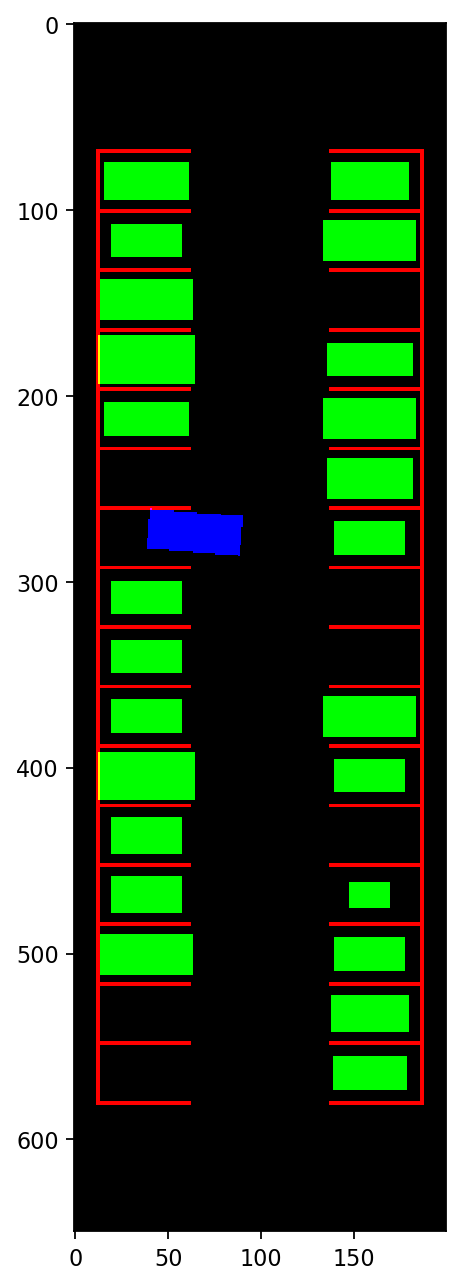

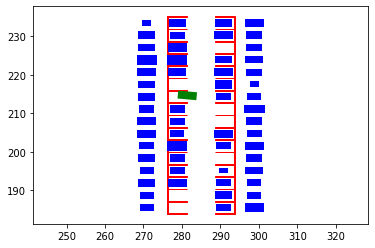

> /media/govvijay/data/carla/carla_0_9_6/PythonAPI/analysis/pkl_reader.py(251)generate_scene_image()
-> for ego_pose in f_test:


In [ ]:
print('Processing\n')
features_combined = []
labels_combined = []
goal_snippets_combined = []
traj_index     = [0]

for file in files_to_process:
    print(file)
    if save_ext == 'pkl':
        res_dict = pickle.load(open(file,'rb'))
    else:
        raise NotImplemented('Invalid Extension')
    
    goals = extract_goals(res_dict)
    parking_lot = res_dict['parking_lot']
    ego_dimensions = res_dict['ego_dimensions']
    static_object_list = res_dict['static_object_list']
    
    try:
        ego_trajectory, start_ind, switch_ind, end_ind, goal_ind = \
             extract_full_trajectory(res_dict, goals, prune_start, prune_end, \
                                     min_vel_thresh, exclude_collisions)

        features, labels, goal_snpts = \
            get_ego_trajectory_prediction_snippets(ego_trajectory, start_ind, switch_ind, end_ind, goal_ind, \
                                           goals, Nhist, Npred, Nskip, dt, ego_frame=ego_trans)
        
        feature_images = generate_scene_image(features, parking_lot, ego_dimensions, static_object_list)
        
        features_combined.extend(features)
        labels_combined.extend(labels)
        goal_snippets_combined.extend(goal_snpts)
        traj_index.append(len(features) + traj_index[-1])
        
    except ValueError as e:
        print(file, e)
assert(len(features_combined) == len(labels_combined) == len(goal_snippets_combined))

'''
#     # for debugging, ensure data shuffle works.
#     ind = -2
#     plt.plot(features_combined[ind][:,0], features_combined[ind][:,1], 'b')
#     plt.plot(labels_combined[ind][:,0], labels_combined[ind][:,1], 'r')
#     for g in goal_snippets_combined[ind]:
#         plt.plot(g[0], g[1], 'kx')
#     plt.show()
#     plt.plot(features_combined[ind+1][:,0], features_combined[ind+1][:,1], 'b')
#     plt.plot(labels_combined[ind+1][:,0], labels_combined[ind+1][:,1], 'r')
#     for g in goal_snippets_combined[ind+1]:
#         plt.plot(g[0], g[1], 'kx')
#     plt.show()
N_instances = len(features_combined)
dataset_dict = {}
dataset_dict['features'] = features_combined
dataset_dict['goals']  = goal_snippets_combined
dataset_dict['labels'] = labels_combined
dataset_dict['N'] = N_instances
dataset_dict['traj_idx'] = traj_index[:-1]

pickle.dump(dataset_dict, open(dataset_name + '.pkl', 'wb'))

if shuffle:
    features_combined, labels_combined, goal_snippets_combined = \
    sku.shuffle(features_combined, labels_combined, goal_snippets_combined, random_state=seed)

if num_folds_cv > 0:
    splits = (N_instances // num_folds_cv) * np.ones(num_folds_cv)
    splits[:N_instances % num_folds_cv] += 1
    
    ind_limits = np.cumsum(splits).astype(np.int)
    
    for i in range(len(ind_limits)):
        if i == 0:
            ind_start = 0
        else:
            ind_start = ind_limits[i-1]
        ind_end = ind_limits[i]
        
        dataset_kfold = {}
        dataset_kfold['features'] = features_combined[ind_start:ind_end]
        dataset_kfold['goals'] = goal_snippets_combined[ind_start:ind_end]
        dataset_kfold['labels'] = labels_combined[ind_start:ind_end]
        dataset_kfold['N'] = ind_end - ind_start
        pickle.dump(dataset_kfold, open(dataset_name + '_fold_%d.pkl' % i, 'wb'))
                
print('Finished\n')
'''